# Visualisations and descriptive statistics

This notebook contains some basic visualisations and descriptive statistics.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
figsize = (12, 9)

In [2]:
import pandas as pd
import glob

In [3]:
dataframes = []

for f in glob.glob("fallzahlen_kanton_total_csv/COVID19_Fallzahlen_Kanton_*total.csv"):
    dataframes.append(pd.read_csv(f))

df = pd.concat(dataframes)

df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [4]:
df.head()

,TotalPosTests1,abbreviation_canton_and_fl,current_hosp_non_resident,current_hosp_resident,current_quarantined_riskareatravel,current_quarantined_total,date,ncumul_ICF,ncumul_ICU,ncumul_conf,ncumul_confirmed_non_resident,ncumul_deceased,ncumul_hosp,ncumul_released,ncumul_tested,ncumul_vent,ninst_ICU_intub,source,time
0,NaN,AG,NaN,NaN,NaN,NaN,2020-02-26,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,https://www.ag.ch/media/kanton_aargau/themen_1...,08:00
1,NaN,AG,NaN,NaN,NaN,NaN,2020-02-27,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,https://www.ag.ch/media/kanton_aargau/themen_1...,08:00
2,NaN,AG,NaN,NaN,NaN,NaN,2020-02-28,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,https://www.ag.ch/media/kanton_aargau/themen_1...,08:00
3,NaN,AG,NaN,NaN,NaN,NaN,2020-02-29,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,https://www.ag.ch/media/kanton_aargau/themen_1...,08:00
4,NaN,AG,NaN,NaN,NaN,NaN,2020-03-01,NaN,NaN,4.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,https://www.ag.ch/media/kanton_aargau/themen_1...,08:00


In [5]:
def transform_df(df, column, pretty_name):
    """Pick out one column of interest"""
    df = (df
          .rename(columns={"abbreviation_canton_and_fl": "Canton",
                           column: pretty_name,
                           "date": "Date"})
          .pivot_table(index="Date",
                       values=[pretty_name],
                       columns=['Canton'])
         )
    # Create a row for every day
    all_days = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df = df.reindex(all_days)
    # Fill missing values with previous day's number
    df.fillna(method='pad', inplace=True)
    # Now there are only missing values at the start
    # of the series, so set them to zero
    df.fillna(value=0, inplace=True)
    return df


def time_to_double(series):
    """Compute how long it took for the most recent doubling"""
    last_day = series.index[-1]
    current = series[last_day]
    half = current / 2
    
    half_day = series.where(series < half).dropna().index[-1]
    return last_day - half_day

## Deaths

Confirmed deaths is a quantity that is known.

In [6]:
deaths_per_canton = transform_df(df, "ncumul_deceased", "Deaths")

In [7]:
# double check
deaths_per_canton.tail().T

2020-11-01  2020-11-02  2020-11-03  2020-11-04  2020-11-05
       Canton                                                            
Deaths AG            80.0        84.0        86.0        88.0        88.0
       AI             2.0         5.0         5.0         6.0         7.0
       AR             8.0        10.0        11.0        11.0        11.0
       BE           133.0       139.0       145.0       153.0       155.0
       BL            41.0        43.0        44.0        44.0        44.0
       BS            54.0        54.0        54.0        54.0        54.0
       FR           140.0       149.0       157.0       170.0       177.0
       GE           337.0       342.0       347.0       350.0       350.0
       GL            14.0        14.0        14.0        15.0        15.0
       GR            53.0        54.0        57.0        57.0        59.0
       JU            36.0        37.0        37.0        40.0        40.0
       LU            33.0        39.0        40.0        42.0        44.0
       NE           108.0       111.0       113.0       116.0       116.0
       NW             4.0         4.0         4.0         4.0         5.0
       OW             5.0         5.0         5.0         5.0         6.0
       SG            73.0        76.0        85.0        91.0        98.0
       SH             8.0         8.0         8.0         9.0         9.0
       SO            19.0        19.0        22.0        23.0        25.0
       SZ            53.0        54.0        54.0        55.0        58.0
       TG            33.0        37.0        37.0        37.0        39.0
       TI           367.0       369.0       372.0       377.0       381.0
       UR             8.0         8.0         8.0         8.0         9.0
       VD           359.0       360.0       366.0       369.0       369.0
       VS           244.0       250.0       260.0       264.0       264.0
       ZG            11.0        11.0        11.0        11.0        11.0
       ZH           191.0       199.0       202.0       206.0       206.0

In [8]:
ch = deaths_per_canton.sum(axis=1)

In [9]:
print("It took {} days for the number of deaths to double.".format(time_to_double(ch).days))

It took 203 days for the number of deaths to double.


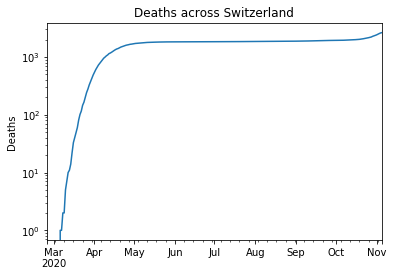

In [10]:
ax = ch.plot(legend=None, title="Deaths across Switzerland")
ax.set_ylabel("Deaths");
ax.set_yscale('log', nonposy='clip')

## Confirmed cases

Read https://ourworldindata.org/coronavirus#cases-of-covid-19 for caveats when it comes to interpreting these numbers.

In [11]:
confirmed_per_canton = transform_df(df, "ncumul_conf", "Cases")

In [12]:
# Look at the last few days to double check data
confirmed_per_canton.tail().T

2020-11-01  2020-11-02  2020-11-03  2020-11-04  2020-11-05
      Canton                                                            
Cases AG          8073.0      8323.0      8770.0      9265.0      9265.0
      AI           321.0       354.0       365.0       389.0       401.0
      AR           732.0       819.0       851.0       892.0       945.0
      BE         14263.0     14844.0     15399.0     16171.0     17149.0
      BL          2936.0      3093.0      3251.0      3340.0      3521.0
      BS          2653.0      2723.0      2800.0      2907.0      3013.0
      FR         10436.0     10948.0     11594.0     12405.0     13294.0
      GE         22326.0     23032.0     24091.0     25354.0     25354.0
      GL           451.0       511.0       546.0       574.0       604.0
      GR          2498.0      2604.0      2739.0      2867.0      2967.0
      JU          2130.0      2221.0      2396.0      2604.0      2604.0
      LU          4561.0      5355.0      5669.0      5993.0      6270.0
      NE          5197.0      5513.0      5682.0      5813.0      5813.0
      NW           504.0       518.0       539.0       585.0       603.0
      OW           414.0       433.0       455.0       468.0       486.0
      SG          8213.0      8893.0      9397.0      9810.0      9969.0
      SH           656.0       768.0       781.0       838.0       883.0
      SO          2410.0      2410.0      2899.0      3066.0      3234.0
      SZ          3142.0      3384.0      3481.0      3577.0      3684.0
      TG          3214.0      3348.0      3498.0      3562.0      3562.0
      TI          7892.0      8225.0      8480.0      8858.0      9310.0
      UR           423.0       486.0       486.0       529.0       541.0
      VD         27492.0     29077.0     30394.0     31386.0     31386.0
      VS         14336.0     15186.0     15829.0     16149.0     16167.0
      ZG          1814.0      1845.0      1895.0      1967.0      2062.0
      ZH         23738.0     24166.0     24622.0     25665.0     26836.0

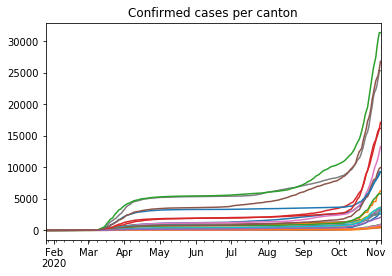

In [13]:
# this is a pretty messy plot, but it can serve as a base
# for picking out a few cantons or some such
ax = confirmed_per_canton.plot(legend=None, title="Confirmed cases per canton")
ax.set_yscale('linear', nonposy='clip')

In [14]:
# Switzerland wide cases
ch = confirmed_per_canton.sum(axis=1)

In [15]:
print("It took {} days for the number of confirmed cases to double.".format(time_to_double(ch).days))

It took 15 days for the number of confirmed cases to double.


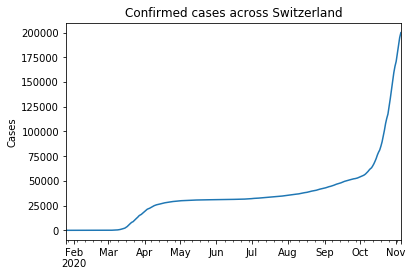

In [16]:
ax = ch.plot(legend=None, title="Confirmed cases across Switzerland")
ax.set_ylabel("Cases");
ax.set_yscale('linear', nonposy='clip')

Created by Tim Head <betatim@gmail.com> licensed under CC-BY-4.

################################ MY CODE ################################

In [17]:
def get_7day_moving_avg(series):
    return series.rolling(window=7).mean()

def get_daily(series):
    return series.diff()

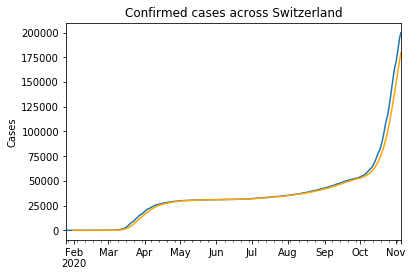

In [18]:
ch_avg = get_7day_moving_avg(ch)

ax1 = ch.plot(legend=None, title="Confirmed cases across Switzerland")
ax1.set_ylabel("Cases");
ax1.set_yscale('linear', nonposy='clip')

ax1 = ch_avg.plot(color='orange')

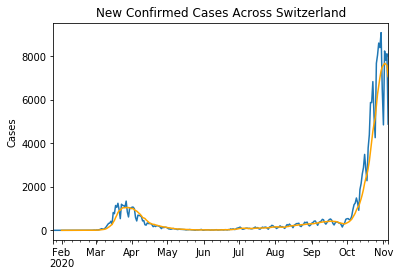

In [19]:
ch_daily = get_daily(ch)
ch_daily_avg = get_7day_moving_avg(ch_daily)

ax1 = ch_daily.plot(legend=None, title="New Confirmed Cases Across Switzerland")
ax1.set_ylabel("Cases");
ax1.set_yscale('linear', nonposy='clip')

ax1 = ch_daily_avg.plot(color='orange')